In [29]:
!pip install -U langchain langchain-core langgraph pydantic langchain-google-genai python-dotenv


In [30]:
from typing import Optional, Sequence, Annotated, Literal
import operator
from pydantic import BaseModel, Field
from datetime import datetime
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState, add_messages
from langgraph.types import Command
from langchain.chat_models import init_chat_model
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, get_buffer_string


In [31]:
load_dotenv()
print("✅ Google API Key Loaded:", bool(os.getenv("GOOGLE_API_KEY")))


✅ Google API Key Loaded: True


In [32]:
class AgentInputState(MessagesState):
    pass

class AgentState(MessagesState):
    research_brief: Optional[str]
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    raw_notes: Annotated[list[str], operator.add] = []
    notes: Annotated[list[str], operator.add] = []
    final_report: Optional[str]


In [33]:
class ClarifyWithUser(BaseModel):
    need_clarification: bool = Field(description="Whether clarification is needed")
    question: Optional[str] = Field(description="Question to ask the user for clarification")
    verification: Optional[str] = Field(description="Verification message confirming understanding")

class ResearchQuestion(BaseModel):
    research_brief: str = Field(description="Comprehensive research brief")


In [34]:
clarify_with_user_instructions = """
You are a research assistant helping to clarify research requests.
Given the conversation history, determine if you need more information.

Conversation History:
{messages}

Today's date: {date}

If the request is clear enough to begin research, respond with:
- need_clarification: false
- verification: A brief confirmation of what you'll research
- question: "N/A"

If you need more information, respond with:
- need_clarification: true
- verification: "N/A"
- question: A specific question to clarify the research needs
"""

transform_messages_into_research_topic_prompt = """
Based on the conversation history, create a comprehensive research brief.
The brief should include:
- Clear research objectives
- Key questions to answer
- Scope and limitations
- Any specific requirements mentioned

Conversation History:
{messages}

Today's date: {date}
"""


In [47]:
from datetime import datetime
import platform

def get_today_str() -> str:
    day_format = "%#d" if platform.system() == "Windows" else "%-d"
    return datetime.now().strftime(f"%a %b {day_format}, %Y")

model = init_chat_model(
    model="models/gemini-2.5-pro",
    model_provider="google_genai",
    temperature=0.0
)


In [48]:
def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    structured_output_model = model.with_structured_output(ClarifyWithUser)
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]),
            date=get_today_str()
        ))
    ])
    if response.need_clarification:
        return Command(goto=END, update={"messages": [AIMessage(content=response.question)]})
    else:
        return Command(goto="write_research_brief", update={"messages": [AIMessage(content=response.verification)]})


In [49]:
def write_research_brief(state: AgentState):
    structured_output_model = model.with_structured_output(ResearchQuestion)
    response = structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }


In [50]:
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)
scope_research = deep_researcher_builder.compile()


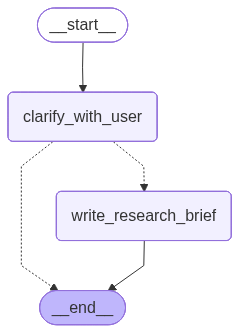

In [51]:
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display

checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))


In [52]:
result = scope.invoke(
    {
        "messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]
    },
    config={"configurable": {"thread_id": "test-thread-1"}}
)

result


{'messages': [HumanMessage(content='I want to research the best coffee shops in San Francisco.', additional_kwargs={}, response_metadata={}, id='eb0859f8-4570-4f01-8647-3fd6062f89bd'),
  AIMessage(content='When you say "best," what do you mean? For example, are you looking for the best-tasting coffee, the best Wi-Fi, or the best atmosphere?', additional_kwargs={}, response_metadata={}, id='9f171809-15e5-4249-b2e0-b392c4f52007')],
 'supervisor_messages': [],
 'raw_notes': [],
 'notes': []}